In [1]:
import torch
from torch_geometric.datasets import TUDataset

In [2]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting data\TUDataset\MUTAG\MUTAG.zip
Processing...
Done!

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [3]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [4]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [5]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(batch=[1169], edge_attr=[2592, 4], edge_index=[2, 2592], x=[1169, 7], y=[64])

Step 2:
Number of graphs in the current batch: 64
Batch(batch=[1116], edge_attr=[2444, 4], edge_index=[2, 2444], x=[1116, 7], y=[64])

Step 3:
Number of graphs in the current batch: 22
Batch(batch=[429], edge_attr=[958, 4], edge_index=[2, 958], x=[429, 7], y=[22])



In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [15]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [20]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    return loss

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [21]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


for epoch in range(1, 176):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6066, Train Acc: 0.8333, Test Acc: 0.7368
Epoch: 002, Loss: 0.5612, Train Acc: 0.8000, Test Acc: 0.7368
Epoch: 003, Loss: 0.4483, Train Acc: 0.8333, Test Acc: 0.7105
Epoch: 004, Loss: 0.4561, Train Acc: 0.8133, Test Acc: 0.7105
Epoch: 005, Loss: 0.5360, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 006, Loss: 0.3752, Train Acc: 0.8333, Test Acc: 0.7105
Epoch: 007, Loss: 0.8071, Train Acc: 0.8400, Test Acc: 0.7105
Epoch: 008, Loss: 0.3983, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 009, Loss: 0.3071, Train Acc: 0.8267, Test Acc: 0.7105
Epoch: 010, Loss: 0.3858, Train Acc: 0.8267, Test Acc: 0.7105
Epoch: 011, Loss: 0.2929, Train Acc: 0.8200, Test Acc: 0.7368
Epoch: 012, Loss: 0.2235, Train Acc: 0.8000, Test Acc: 0.7368
Epoch: 013, Loss: 0.5332, Train Acc: 0.8333, Test Acc: 0.7632
Epoch: 014, Loss: 0.4019, Train Acc: 0.8333, Test Acc: 0.7105
Epoch: 015, Loss: 0.3074, Train Acc: 0.8267, Test Acc: 0.7632
Epoch: 016, Loss: 0.4656, Train Acc: 0.8000, Test Acc: 0.7895
Epoch: 0

Epoch: 135, Loss: 0.3513, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 136, Loss: 0.4068, Train Acc: 0.8533, Test Acc: 0.6842
Epoch: 137, Loss: 0.4427, Train Acc: 0.8467, Test Acc: 0.7105
Epoch: 138, Loss: 0.4316, Train Acc: 0.8400, Test Acc: 0.6842
Epoch: 139, Loss: 0.3445, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 140, Loss: 0.5308, Train Acc: 0.8667, Test Acc: 0.6842
Epoch: 141, Loss: 0.5235, Train Acc: 0.8667, Test Acc: 0.6842
Epoch: 142, Loss: 0.2773, Train Acc: 0.8533, Test Acc: 0.7105
Epoch: 143, Loss: 0.4170, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 144, Loss: 0.3675, Train Acc: 0.8733, Test Acc: 0.6842
Epoch: 145, Loss: 0.3138, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 146, Loss: 0.2580, Train Acc: 0.8533, Test Acc: 0.6842
Epoch: 147, Loss: 0.3348, Train Acc: 0.8533, Test Acc: 0.6842
Epoch: 148, Loss: 0.5727, Train Acc: 0.8467, Test Acc: 0.7105
Epoch: 149, Loss: 0.2897, Train Acc: 0.8467, Test Acc: 0.6842
Epoch: 150, Loss: 0.2982, Train Acc: 0.8533, Test Acc: 0.7105
Epoch: 1

In [70]:
final_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
for data in final_loader:
    print(data)

Batch(batch=[2714], edge_attr=[5994, 4], edge_index=[2, 5994], x=[2714, 7], y=[150])


In [71]:
x = model.conv1(data.x, data.edge_index)
x = x.relu()
x = model.conv2(x, data.edge_index)
x = x.relu()
x = model.conv3(x, data.edge_index)

# 2. Readout layer
x = global_mean_pool(x, data.batch) 

In [72]:
x.shape

torch.Size([150, 64])

In [73]:
x

tensor([[ 0.0104,  0.0261,  0.1254,  ...,  0.0156, -0.1207, -0.0571],
        [-0.0156, -0.0010,  0.1657,  ...,  0.0374, -0.1363, -0.0853],
        [ 0.0260,  0.0326,  0.1150,  ...,  0.0135, -0.1281, -0.0523],
        ...,
        [-0.2665,  0.1849, -0.0837,  ..., -0.1741,  0.1978,  0.2073],
        [ 0.6496, -0.5655,  0.8123,  ...,  0.2333, -0.7444, -0.3861],
        [-0.0757,  0.0856,  0.0484,  ..., -0.0336, -0.0009,  0.0312]],
       grad_fn=<TrueDivideBackward0>)

In [42]:
x = model.conv1(train_loader.dataset.data.x, train_loader.dataset.data.edge_index)

In [74]:
data.y

tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 0])

In [78]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=50, c=color, cmap="Set2")
#     plt.legend()
    plt.show()

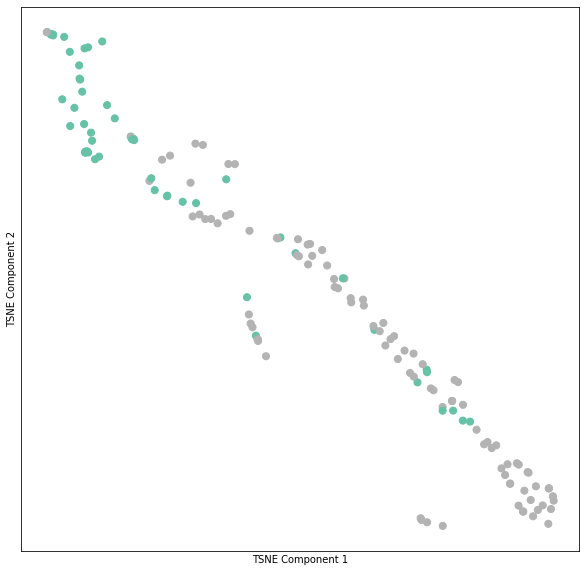

In [79]:
visualize(x, color=data.y)

In [80]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [82]:
model_GNN = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model_GNN)

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [83]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.9490, Train Acc: 0.8467, Test Acc: 0.7368
Epoch: 002, Loss: 0.4740, Train Acc: 0.8533, Test Acc: 0.7105
Epoch: 003, Loss: 0.5340, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 004, Loss: 0.3735, Train Acc: 0.8667, Test Acc: 0.7105
Epoch: 005, Loss: 0.2196, Train Acc: 0.8667, Test Acc: 0.7105
Epoch: 006, Loss: 0.5142, Train Acc: 0.8667, Test Acc: 0.7105
Epoch: 007, Loss: 0.4857, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 008, Loss: 0.3055, Train Acc: 0.8400, Test Acc: 0.7105
Epoch: 009, Loss: 0.4524, Train Acc: 0.8467, Test Acc: 0.7105
Epoch: 010, Loss: 0.4476, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 011, Loss: 0.5342, Train Acc: 0.8333, Test Acc: 0.6579
Epoch: 012, Loss: 0.5596, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 013, Loss: 0.3178, Train Acc: 0.8533, Test Acc: 0.7105
Epoch: 014, Loss: 0.2386, Train Acc: 0.8533, Test Acc: 0.7105
Epoch: 015, Loss: 0.4332, Train Acc: 0.8400, Test Acc: 0.7105
Epoch: 016, Loss: 0.4300, Train Acc: 0.8467, Test Acc: 0.7105
Epoch: 0

Epoch: 135, Loss: 0.3342, Train Acc: 0.8333, Test Acc: 0.6842
Epoch: 136, Loss: 0.3528, Train Acc: 0.8467, Test Acc: 0.6842
Epoch: 137, Loss: 0.3513, Train Acc: 0.8600, Test Acc: 0.6842
Epoch: 138, Loss: 0.4225, Train Acc: 0.8600, Test Acc: 0.6842
Epoch: 139, Loss: 0.6674, Train Acc: 0.8600, Test Acc: 0.6842
Epoch: 140, Loss: 0.5781, Train Acc: 0.8600, Test Acc: 0.6842
Epoch: 141, Loss: 0.5396, Train Acc: 0.8600, Test Acc: 0.6842
Epoch: 142, Loss: 0.4518, Train Acc: 0.8600, Test Acc: 0.6842
Epoch: 143, Loss: 0.4706, Train Acc: 0.8733, Test Acc: 0.6842
Epoch: 144, Loss: 0.3903, Train Acc: 0.8667, Test Acc: 0.6842
Epoch: 145, Loss: 0.4851, Train Acc: 0.8600, Test Acc: 0.7105
Epoch: 146, Loss: 0.3828, Train Acc: 0.8667, Test Acc: 0.6842
Epoch: 147, Loss: 0.2524, Train Acc: 0.8800, Test Acc: 0.7105
Epoch: 148, Loss: 0.2910, Train Acc: 0.8733, Test Acc: 0.7105
Epoch: 149, Loss: 0.3635, Train Acc: 0.8733, Test Acc: 0.6842
Epoch: 150, Loss: 0.4667, Train Acc: 0.8533, Test Acc: 0.7105
Epoch: 1